# Imports

In [80]:
import math
import random
import warnings
from tqdm import tqdm
from itertools import count
from collections import namedtuple, deque

import imageio
from IPython.display import Image

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import gymnasium as gym
from gym.wrappers import TimeLimit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

warnings.simplefilter("ignore", category=(DeprecationWarning, UserWarning))

plt.ion()

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

# Replay Buffer

In [81]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Constants

In [82]:
MAX_EPISODE_LENGTH = 400
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.005
EPS_DECAY = 100
TAU = 0.005
LR = 1e-4
num_episodes = 500

# Greedy Action Selection

In [83]:
def select_action(action_space, state, policy_net, steps_done): 
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1), eps_threshold
    else:
        return torch.tensor([[action_space.sample()]], device=device, dtype=torch.long), eps_threshold

# Optimizer

In [84]:
def optimize_model(optimizer, policy_net, target_net, memory):
    
    if len(memory) < BATCH_SIZE:
        return
 
    # [
    #     Transition(
    #         state=tensor([[-0.0632, -0.9992,  0.0976,  1.4934]]), 
    #         action=tensor([[0]]), 
    #         next_state=tensor([[-0.0831, -1.1954,  0.1274,  1.8149]]), 
    #         reward=tensor([1.])),
    #     Transition(
    #         state=tensor([[ 0.0228, -0.1853,  0.0443,  0.3158]]),
    #         action=tensor([[1]]),
    #         next_state=tensor([[0.0191, 0.0092, 0.0506, 0.0374]]),
    #         reward=tensor([1.])),
    #     Transition(
    #         state=tensor([[ 0.1077, -0.7645, -0.0625,  1.0608]]),
    #         action=tensor([[0]]),
    #         next_state=tensor([[ 0.0924, -0.9587, -0.0413,  1.3332]]),
    #         reward=tensor([1.]))
    # ]
    transitions = memory.sample(BATCH_SIZE) # (batch, Transition())

    # Transition(
    #     state=(tensor([[ 0.1416,  0.9714, -0.1053, -1.3007]]), 
    #            tensor([[ 0.0404,  0.5806, -0.0825, -0.9449]]), 
    #            tensor([[ 0.1183,  1.1655, -0.0739, -1.5695]])), 
    #     action=(tensor([[0]]), 
    #             tensor([[0]]), 
    #             tensor([[0]])), 
    #     next_state=(tensor([[ 0.1610,  0.7777, -0.1313, -1.0428]]),
    #                 tensor([[ 0.0520,  0.3867, -0.1014, -0.6793]]),
    #                 tensor([[ 0.1416,  0.9714, -0.1053, -1.3007]])), 
    #     reward=(tensor([1.]), 
    #             tensor([1.]), 
    #             tensor([1.]))
    # )
    batch = Transition(*zip(*transitions)) # Transition((batch,), (batch,), (batch,), (batch,))

    # tensor([True, True, True])
    is_next_states_batch = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool) # (batch,)

    # tensor([[-0.0600, -0.9983,  0.0744,  1.5364],
        # [-0.0340, -0.2066, -0.0314,  0.2412],
        # [-0.0540, -0.4244,  0.0198,  0.6019]]
    # )
    next_states_batch = torch.cat([s for s in batch.next_state if s is not None]) # (batch, 4)

    # tensor([[-1.2915e-01, -2.3612e-01,  6.0752e-02,  3.2493e-01],
    #     [ 1.5827e-01,  8.0256e-01, -1.9460e-01, -1.3580e+00],
    #     [-1.2387e-03,  2.1060e-01,  4.4813e-02, -3.1255e-01]]
    # )
    state_batch = torch.cat(batch.state) # (batch, 4)

    # tensor([[1],
    #     [0],
    #     [0]]
    # )
    action_batch = torch.cat(batch.action) # (batch, 1)

    # tensor([1., 1., 1.])
    reward_batch = torch.cat(batch.reward) # (batch,)
    
    # policy_net finds the 'Q values' for each 'Action in the state'
    # gather returns the Q value for the action that was 'Actually taken'
    state_action_values = policy_net(state_batch).gather(1, action_batch) # (batch, 1)

    # argmax-a[Q(s', a)]
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[is_next_states_batch] = target_net(next_states_batch).max(1).values # (batch,)

    # Compute the expected Q values
    expected_state_action_values = reward_batch + (next_state_values * GAMMA) # (batch,)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1)) # (batch, 1)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# Plot

In [85]:
def plot_progress(episode_mean, episode_length):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    ax1.plot(episode_mean, linestyle='-', color='b', label="Overall Scores")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Episode Mean", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.plot(episode_length, linestyle='-', color='r', label="Other Series")
    ax2.set_ylabel("Episode Length", color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    plt.title("Episode performace")
    fig.tight_layout()
    plt.show()

# Render

In [86]:
def show_gif(env, policy, num_steps):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    frames = []
    total_reward = 0
    
    for t in range(num_steps):
        action = policy(state).max(1).indices.view(1, 1)
        state, reward, done, _, _ = env.step(action.item())
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        total_reward += reward
        
        frame = env.render()
        frames.append(frame)
        
        if done:
            break
            
    filename = "cartpole.gif"
    imageio.mimsave(filename, frames, fps=30)
    display(Image(filename))
    print(f'Episode length: {t+1} | Total reward: {total_reward}) | Average Reward: {total_reward/t:.2f}')

# Deep Q-Network

In [87]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        
        hidden_sizes = [512, 256, 128, 64]
        layers = []
        
        layers.append(nn.Linear(n_observations, hidden_sizes[0]))
        layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_sizes[-1], n_actions))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Customer Environment

In [88]:
class CustomCartPole(gym.Wrapper):
    def __init__(self, max_episode_steps, render_mode=None):
        self.env = gym.make("CartPole-v1", render_mode=render_mode, max_episode_steps=max_episode_steps)
        self.env.unwrapped.theta_threshold_radians = np.inf

        super().__init__(self.env)        

    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)

        self.env.unwrapped.state = np.array([np.random.uniform(-2.0, 2.0), 0.0, np.random.uniform(-np.pi, np.pi), 0.0])
        
        obs = np.array(self.env.unwrapped.state, dtype=np.float32)

        return obs, info
    
    def step(self, action):
        next_state, _, done, truncated, info = self.env.step(action)

        move_pos = next_state[0] # -4.8 to 4.8
        move_velocity = next_state[1] # -inf to inf
        theta = next_state[2] # -π to π
        theta_velocity = next_state[3] # -inf to inf
        
        reward = np.cos(theta)
        reward -= np.square(move_pos)
        reward -= 0.05 * np.square(theta_velocity)
        
        return next_state, reward, done, truncated, info

# Training

Running mean = -0.39(0.23) | Running length = 386.70(400) | Exploration = 0.01: 100%|██████████| 500/500 [13:55<00:00,  1.67s/it] 


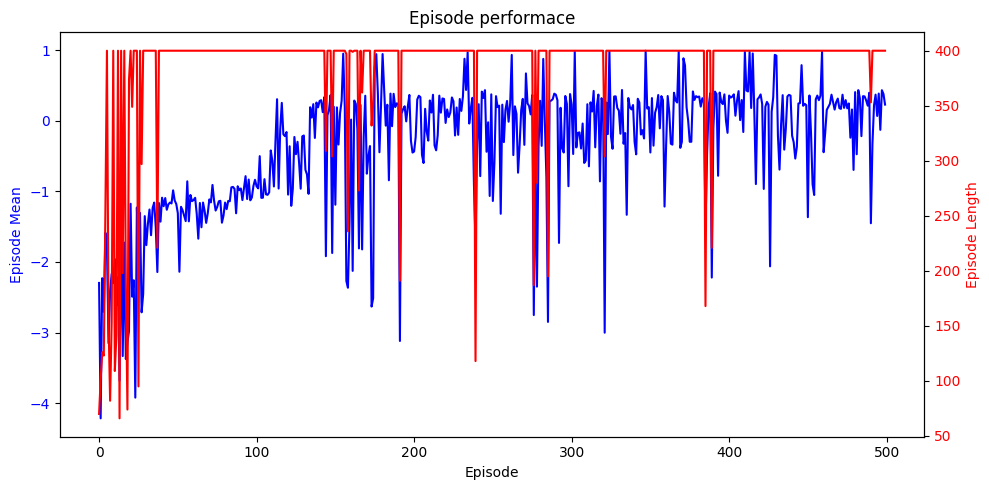

In [96]:
env = CustomCartPole(max_episode_steps=MAX_EPISODE_LENGTH)
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(10000)

episode_length = []
episode_mean = []
running_mean = 0
running_length = 0
episode_count = 0
steps_done = 0

progress_bar = tqdm(range(num_episodes))

for i_episode in progress_bar:
    state, info = env.reset()
    
    # (1, 4)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_average = 0
    
    for t in count():
        # (1, 1)
        action, exploration = select_action(env.action_space, state, policy_net, i_episode)
        steps_done += 1
        
        # (4,)       1.0     False       False
        observation, reward, terminated, truncated, _ = env.step(action.item())
        
        # (1)
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            # (1, 4)
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            
        # state (1, 4):  tensor([[-0.0055,  0.0394,  0.0167, -0.0443]]) 
        # action (1, 1):  tensor([[0]])
        # next_state (1, 4):  tensor([[-0.0047, -0.1559,  0.0158,  0.2536]])
        # reward (1):  tensor([1.])

        #          (1, 4), (1, 1), (1, 4),     (1)
        memory.push(state, action, next_state, reward)
        episode_average = episode_average + (reward.item() - episode_average) / (t+1)
        
        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model(optimizer, policy_net, target_net, memory)
        
        # Soft update of the target network's weights     
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_mean.append(episode_average)
            episode_length.append(t+1)
            
            episode_count += 1
            running_mean = running_mean + (episode_mean[-1] - running_mean) / episode_count
            running_length = running_length + (episode_length[-1] - running_length) / episode_count
            
            break

    if episode_average >= 1:
        break
    
    progress_bar.set_description(f"Running mean = {running_mean:.2f}({episode_mean[-1]:.2f}) | "
                                 f"Running length = {running_length:.2f}({episode_length[-1]}) | "
                                 f"Exploration = {exploration:.2f}")

plot_progress(episode_mean, episode_length)

# Testing

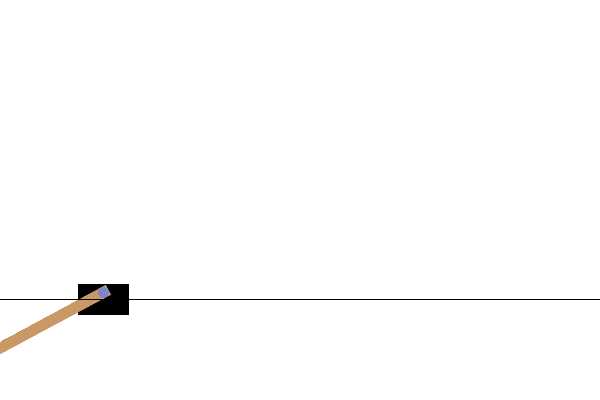

Episode length: 400 | Total reward: 127.51799201266483) | Average Reward: 0.32


In [98]:
env = CustomCartPole(max_episode_steps=MAX_EPISODE_LENGTH, render_mode='rgb_array')
show_gif(env, policy_net, MAX_EPISODE_LENGTH)

# Generating Gifs

In [99]:
def save_gifs(env, policy, num_episodes, num_steps=500):
    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        frames = []
        total_reward = 0

        for t in range(num_steps):
            action = policy(state).max(1).indices.view(1, 1)
            state, reward, done, _, _ = env.step(action.item())
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            total_reward += reward
            
            frame = env.render()
            frames.append(frame)
            
            if done:
                break

        filename = f"cartpole_episode_{episode}.gif"
        imageio.mimsave(filename, frames, fps=30, loop=0)
        print(f'Saved: {filename} | Episode length: {t+1} | Total reward: {total_reward:.2f} | Avg Reward: {total_reward/t:.2f}')

In [102]:
env = CustomCartPole(max_episode_steps=MAX_EPISODE_LENGTH, render_mode='rgb_array')
save_gifs(env, policy_net, 10, MAX_EPISODE_LENGTH)

Saved: cartpole_episode_1.gif | Episode length: 400 | Total reward: 112.03 | Avg Reward: 0.28
Saved: cartpole_episode_2.gif | Episode length: 400 | Total reward: 106.26 | Avg Reward: 0.27
Saved: cartpole_episode_3.gif | Episode length: 400 | Total reward: 141.53 | Avg Reward: 0.35
Saved: cartpole_episode_4.gif | Episode length: 400 | Total reward: 141.96 | Avg Reward: 0.36
Saved: cartpole_episode_5.gif | Episode length: 400 | Total reward: 337.01 | Avg Reward: 0.84
Saved: cartpole_episode_6.gif | Episode length: 400 | Total reward: 166.28 | Avg Reward: 0.42
Saved: cartpole_episode_7.gif | Episode length: 400 | Total reward: -8.82 | Avg Reward: -0.02
Saved: cartpole_episode_8.gif | Episode length: 400 | Total reward: 144.83 | Avg Reward: 0.36
Saved: cartpole_episode_9.gif | Episode length: 400 | Total reward: 129.91 | Avg Reward: 0.33
Saved: cartpole_episode_10.gif | Episode length: 400 | Total reward: 127.04 | Avg Reward: 0.32


# Saving Policy

In [103]:
torch.save(policy_net.state_dict(), "custom_cartpole_policy.pth")